In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/PASS00589'
setwd(data_folder)

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()


3847


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample1,1,1,8488644.0,B_D140314_SGSDSsample1_R01_MSG_T0.mzML
1,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample4,4,10,2937769.0,B_D140314_SGSDSsample4_R01_MSG_T0.mzML
2,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample5,5,14,313403.4,B_D140314_SGSDSsample5_R02_MSG_T0.mzML
3,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample6,6,16,8892265.0,B_D140314_SGSDSsample6_R01_MSG_T0.mzML
4,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample7,7,19,1741688.0,B_D140314_SGSDSsample7_R01_MSG_T0.mzML


#### overlap of proteins quantified

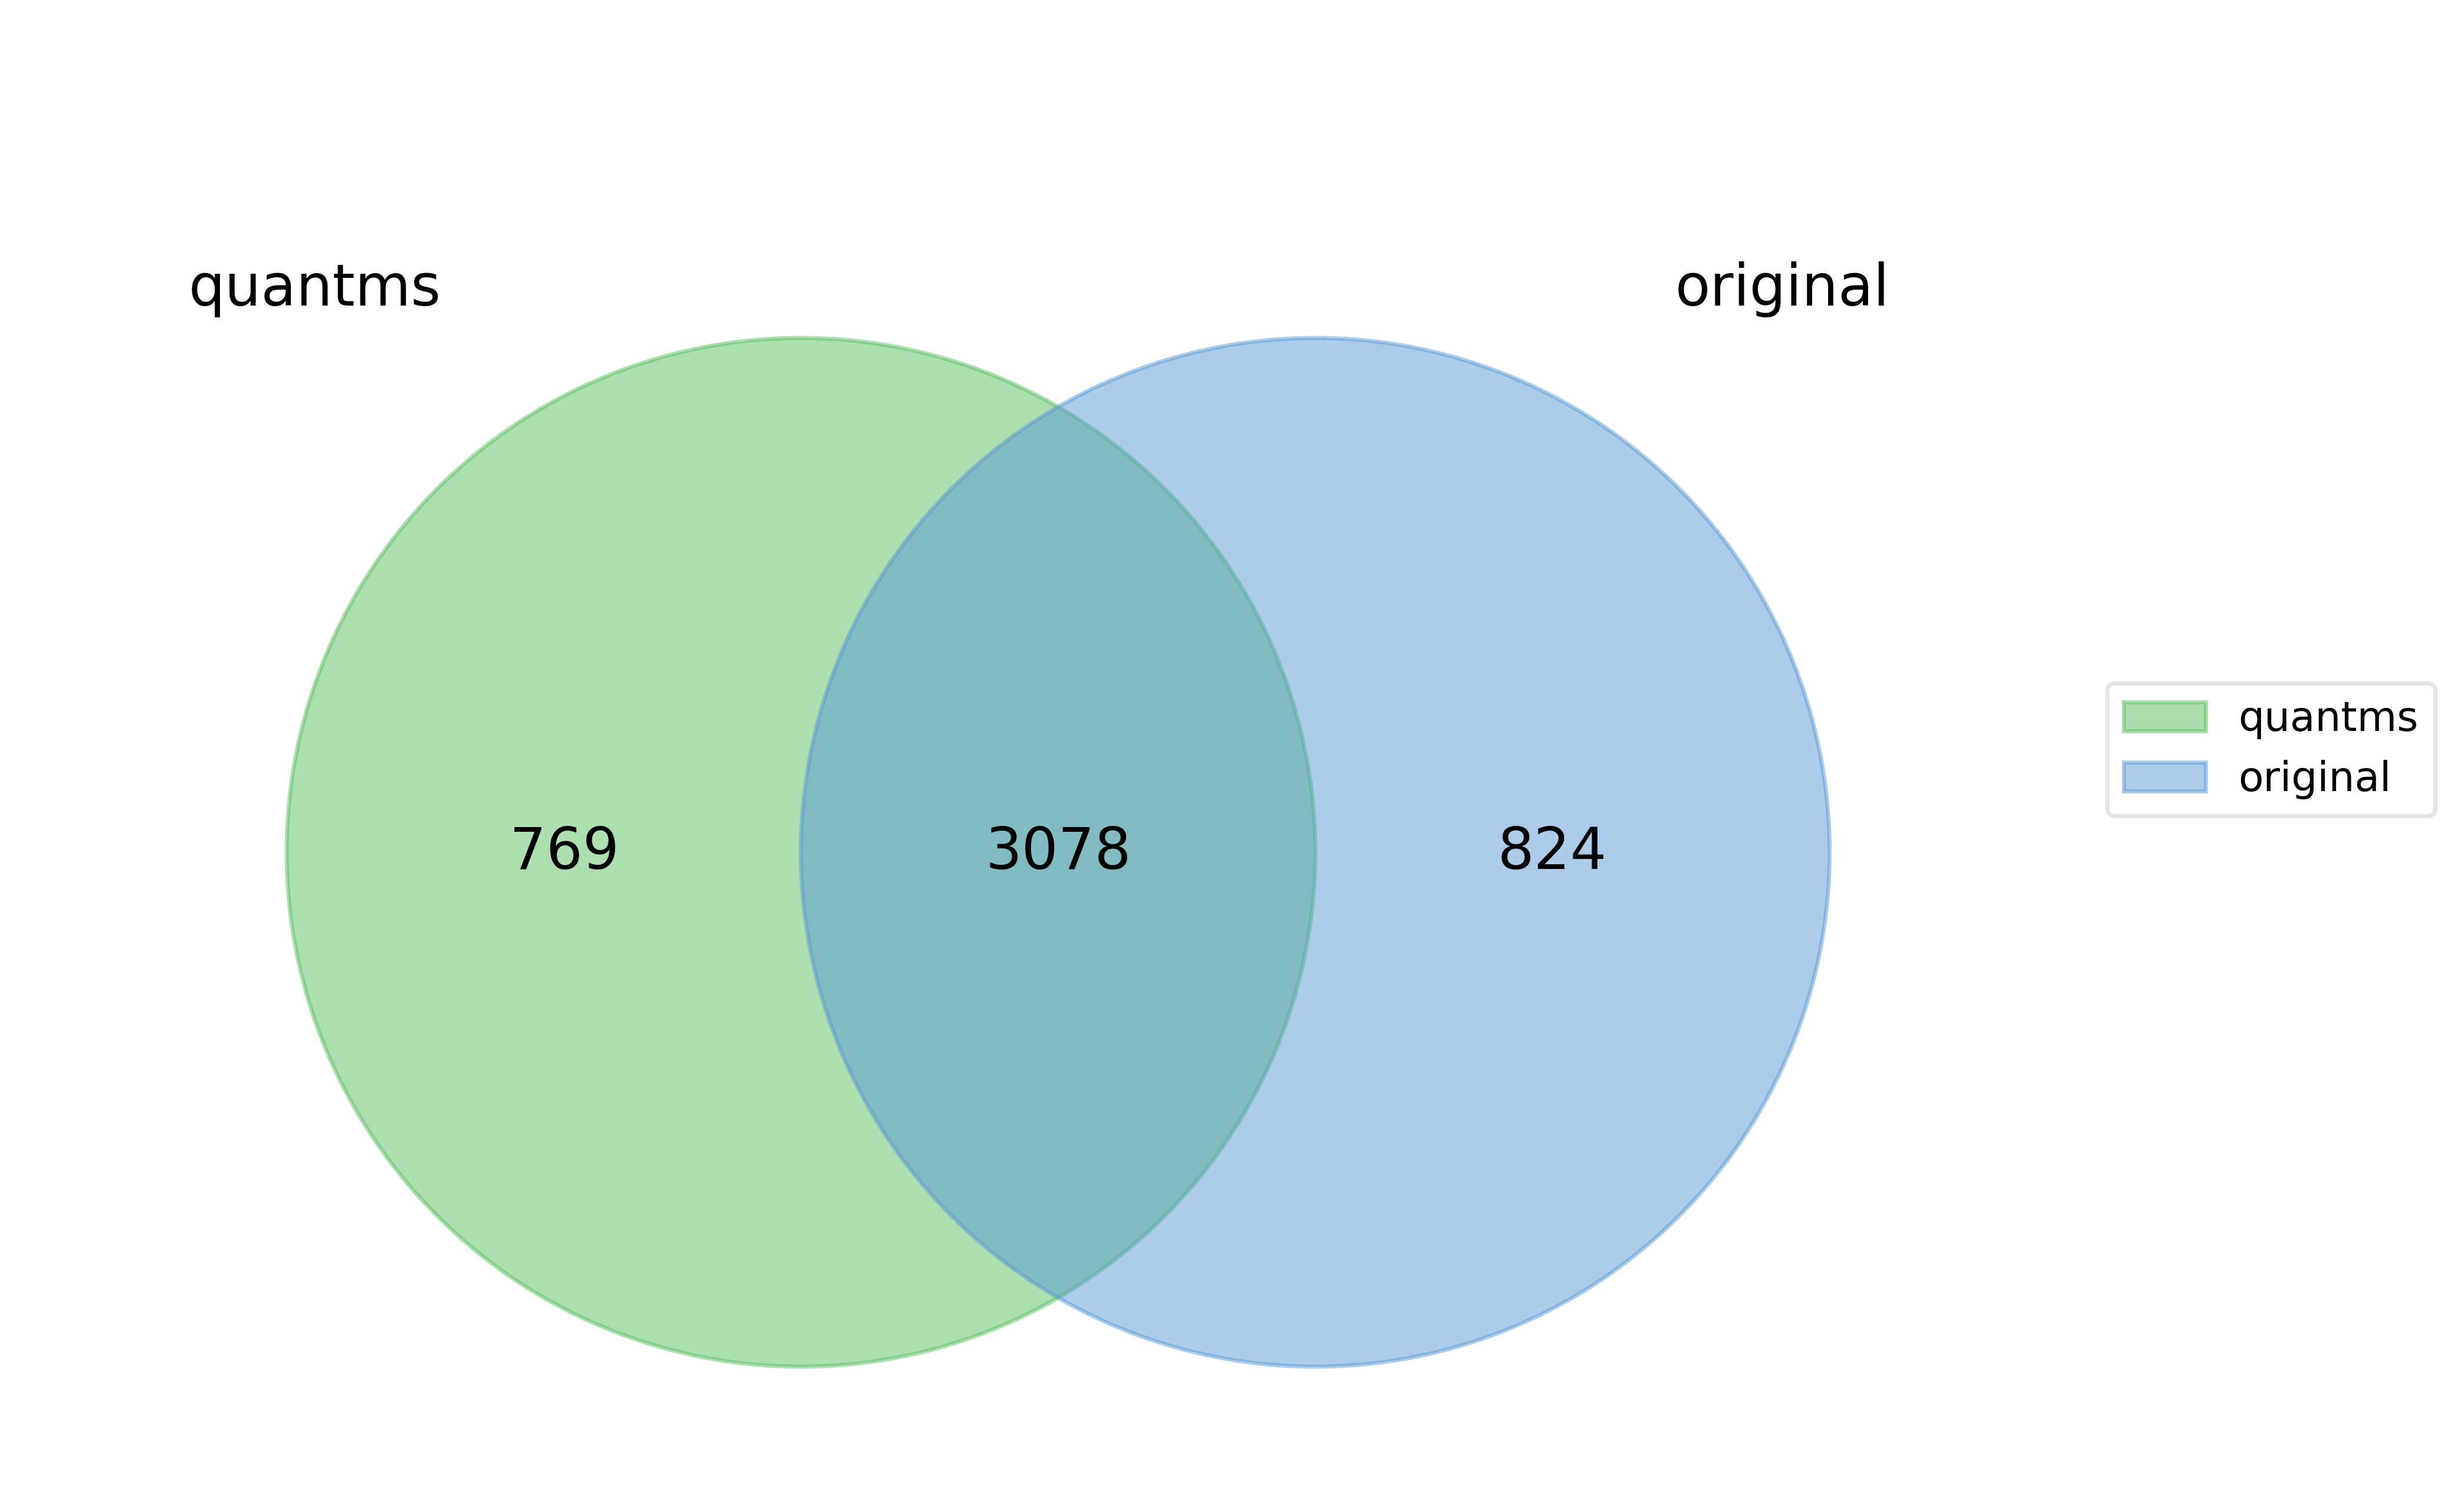

In [5]:
from pyvenn import venn
quantms['P1'] = quantms.apply(lambda x: ";".join(x['ProteinName'].split("|")[1::2]), axis=1)

original = pd.read_excel("supp_M114.044305_mcp.M114.044305-3.xlsx", header=0, sheet_name= "Shotgun-RAW")
original = original.dropna(how="any")
original = original[-original['Proteins'].str.contains("CON_")]
original.head()
labels = venn.get_labels([set(quantms['P1']), set(original['Proteins'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=500)
plt.show()

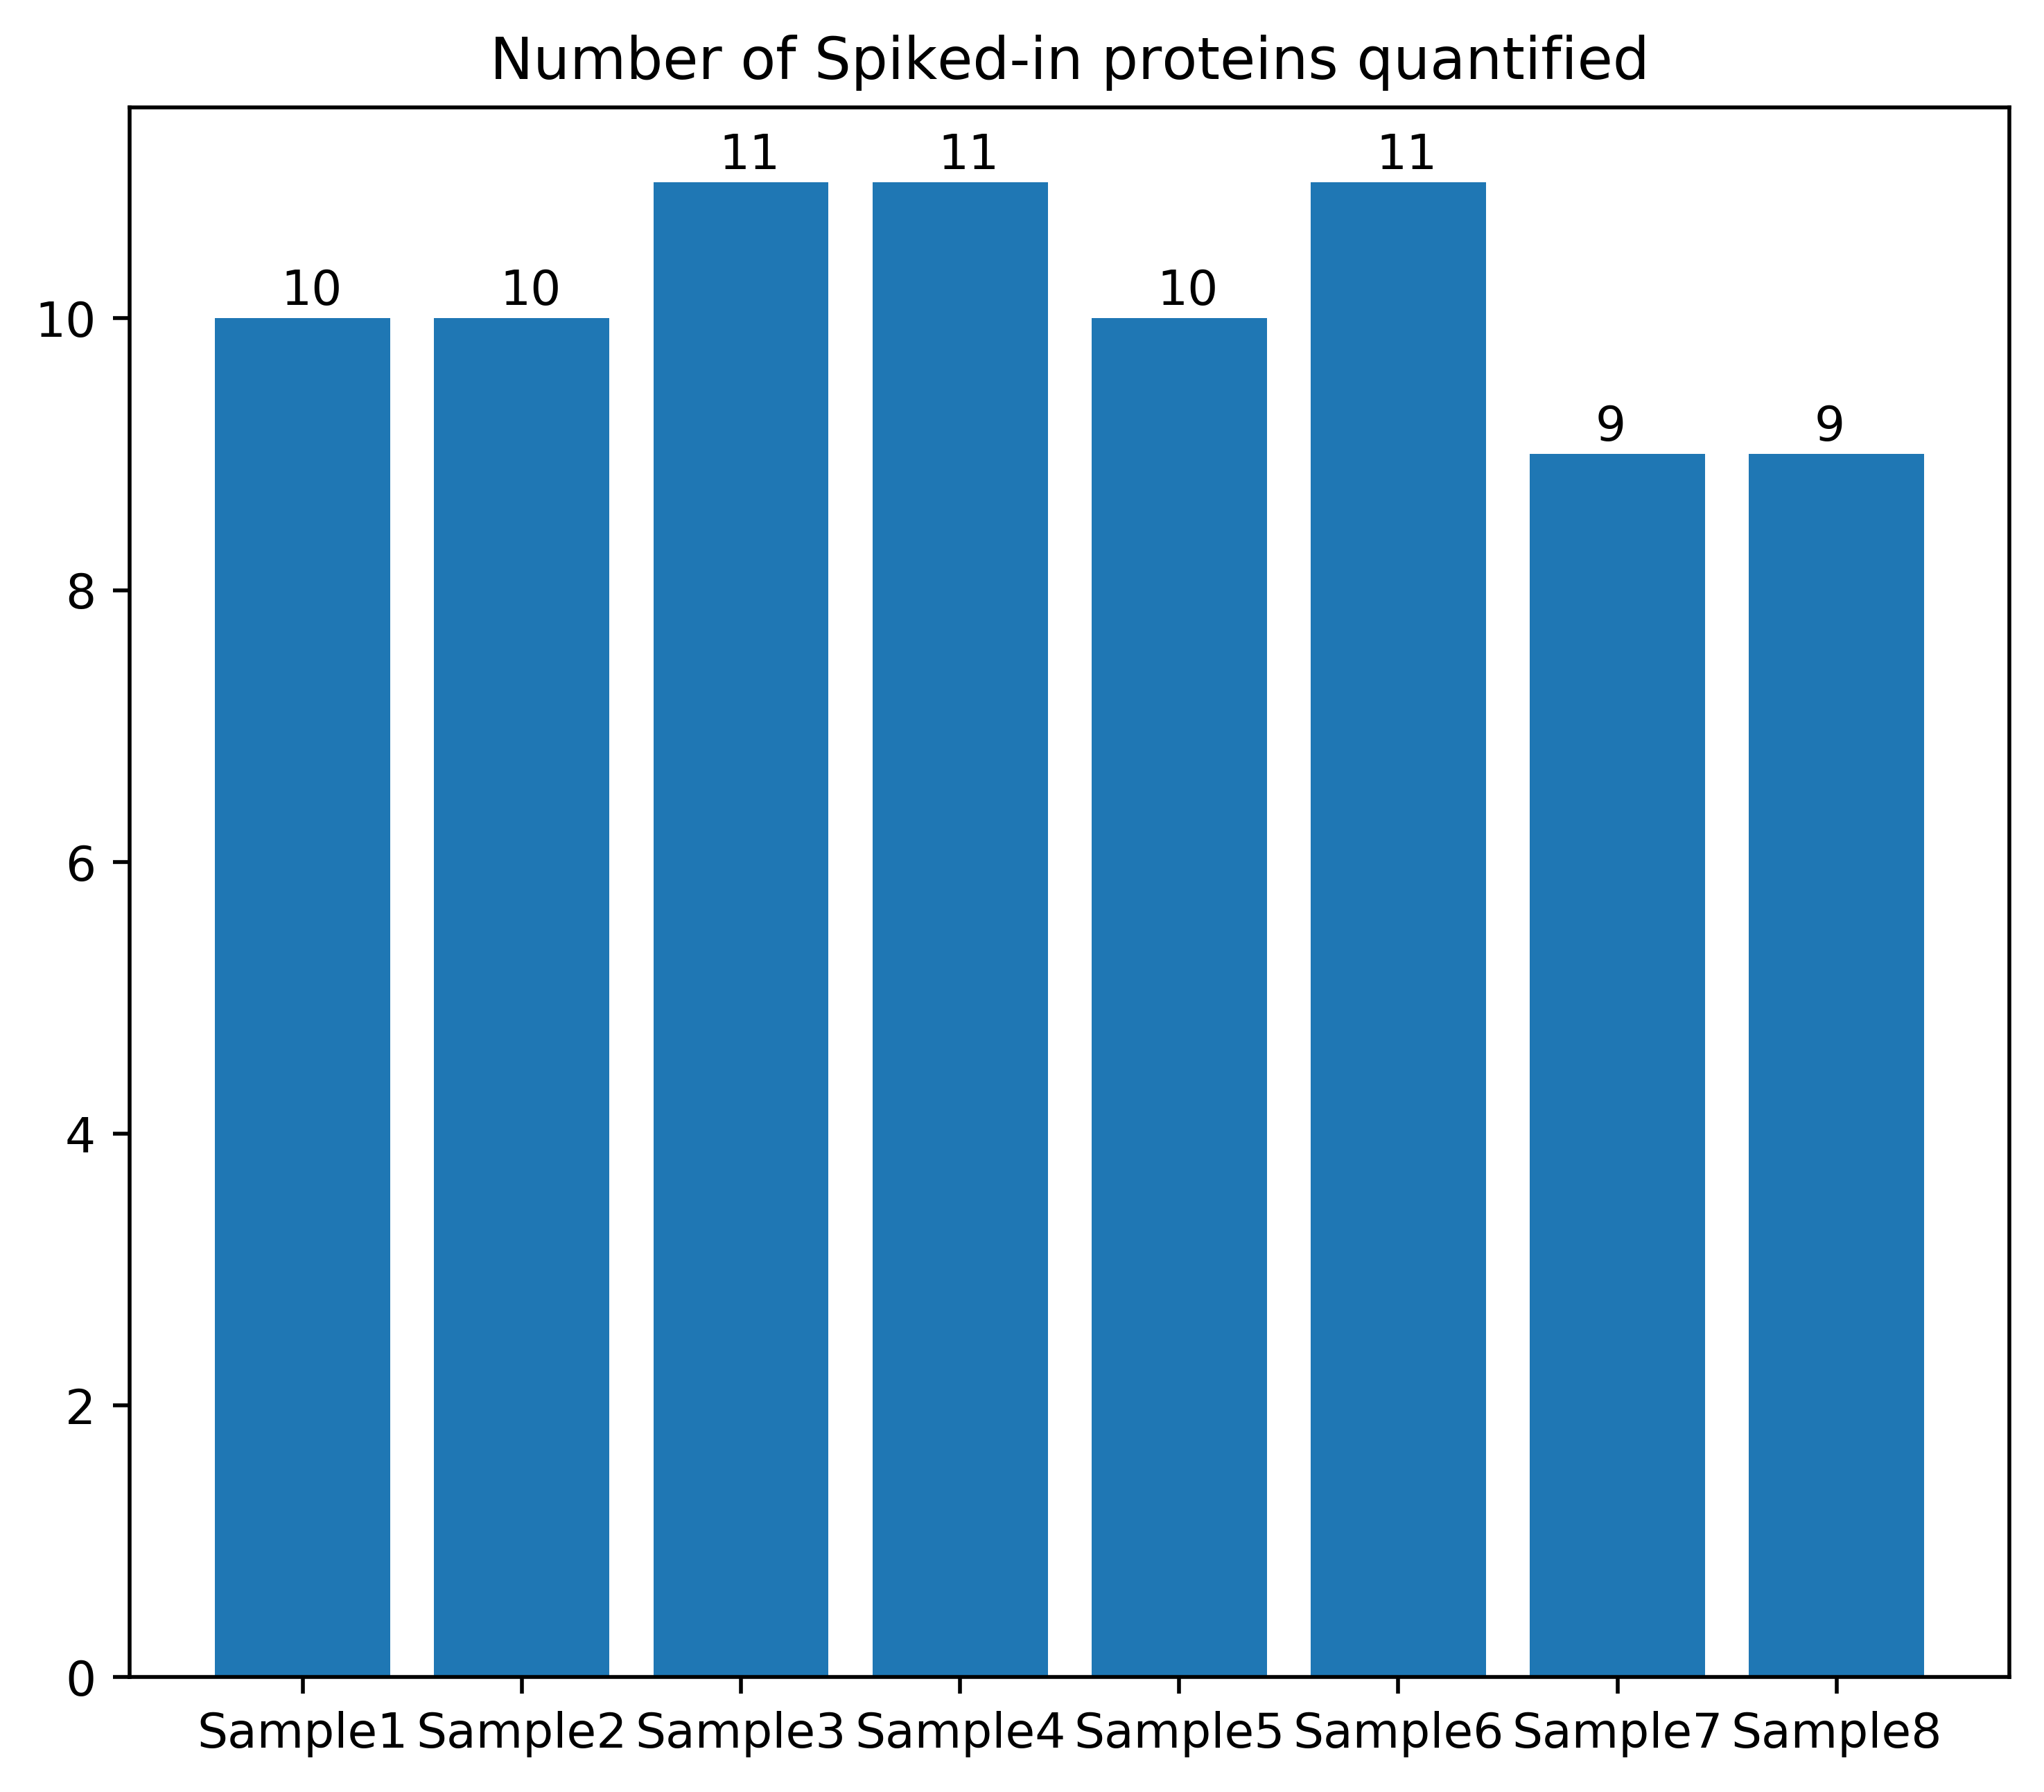

In [6]:
number_of_ups1 = dict()
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition] = len((set(quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(7,6), dpi=500)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: int(item[0].replace("Sample",""))):
    num.append(value)
    label.append(key.replace(" ", ""))
for x, y in zip(range(8), num):
    plt.text(x-0.1, y+0.1, y)

plt.bar(range(8), num)
plt.title("Number of Spiked-in proteins quantified")
plt.xticks(range(8),label)
plt.show()

### Reproducibility between Analytical Replicate before msstats process

#### UPS1 CV . Filtered out missing ups1 protein but not fill or Imputation

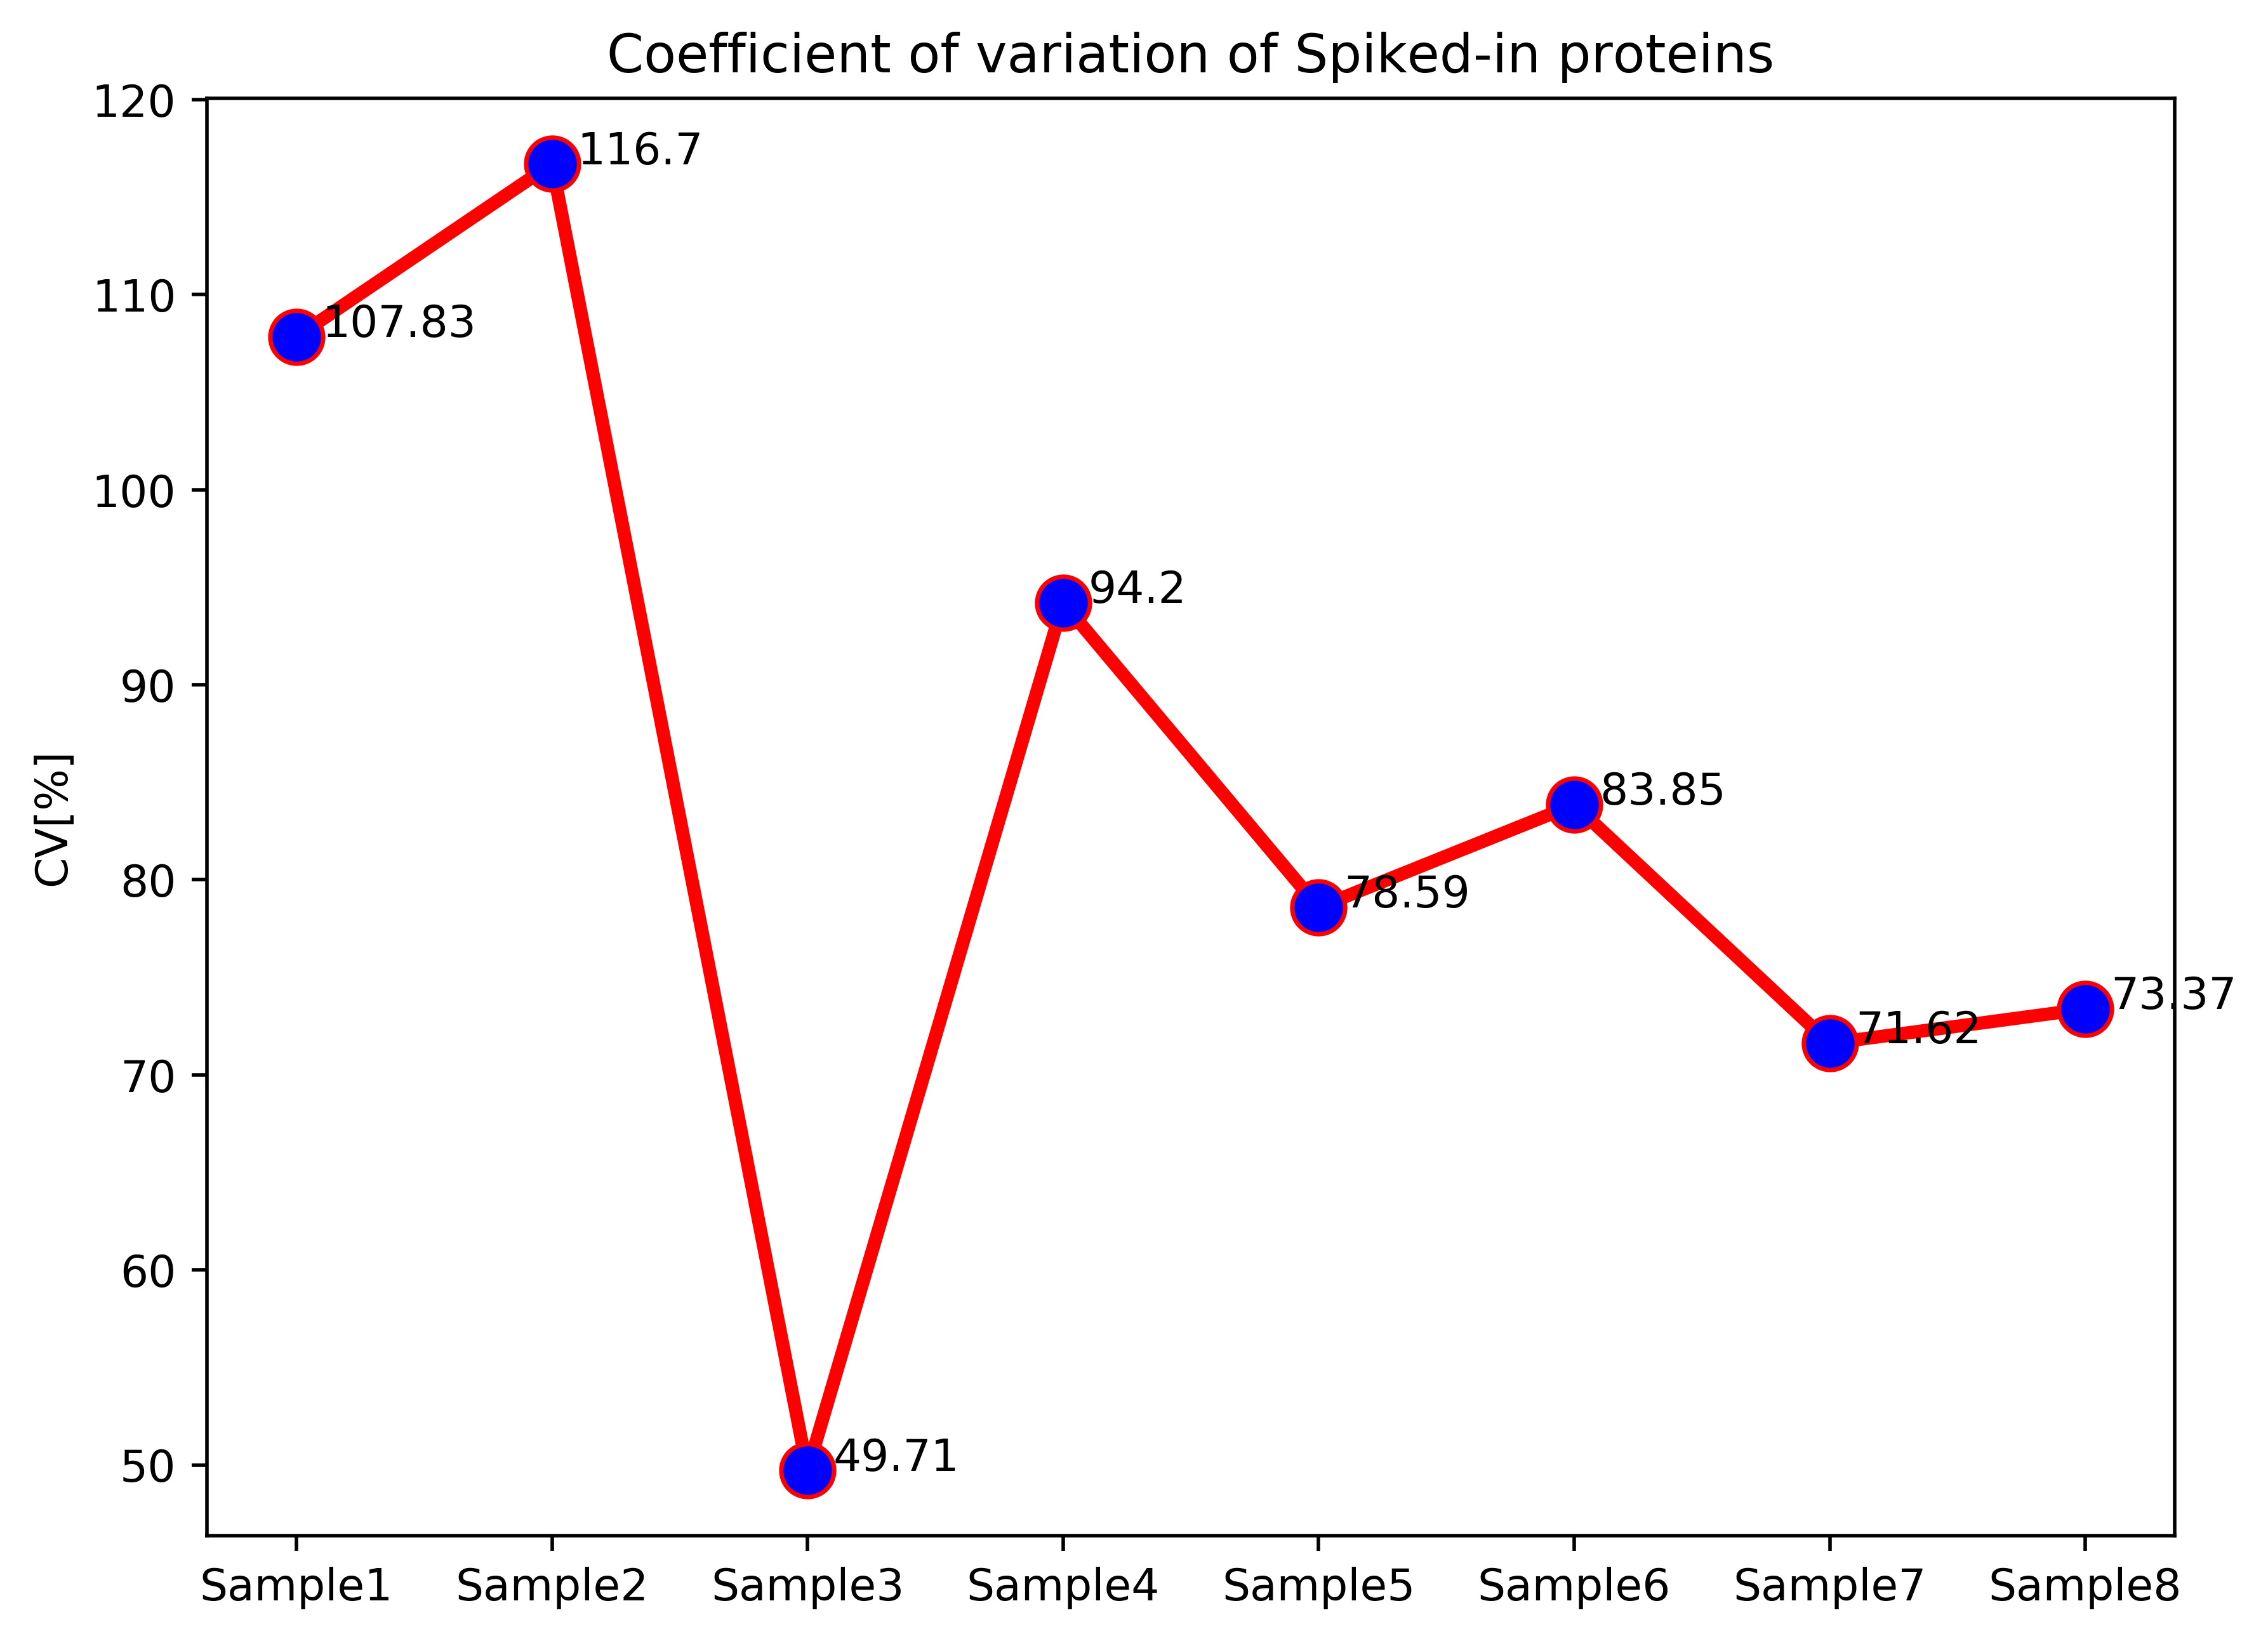

In [7]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
                
            tech_intensity.append(np.sum(pep_intensity))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace("Sample","")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition)
    
plt.plot(range(8), cvs, linewidth=3, color='r', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(range(8), xticks)
for i in range(8):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of Spiked-in proteins')
plt.show()

#### Calcaulate CV of backgroud Proteins

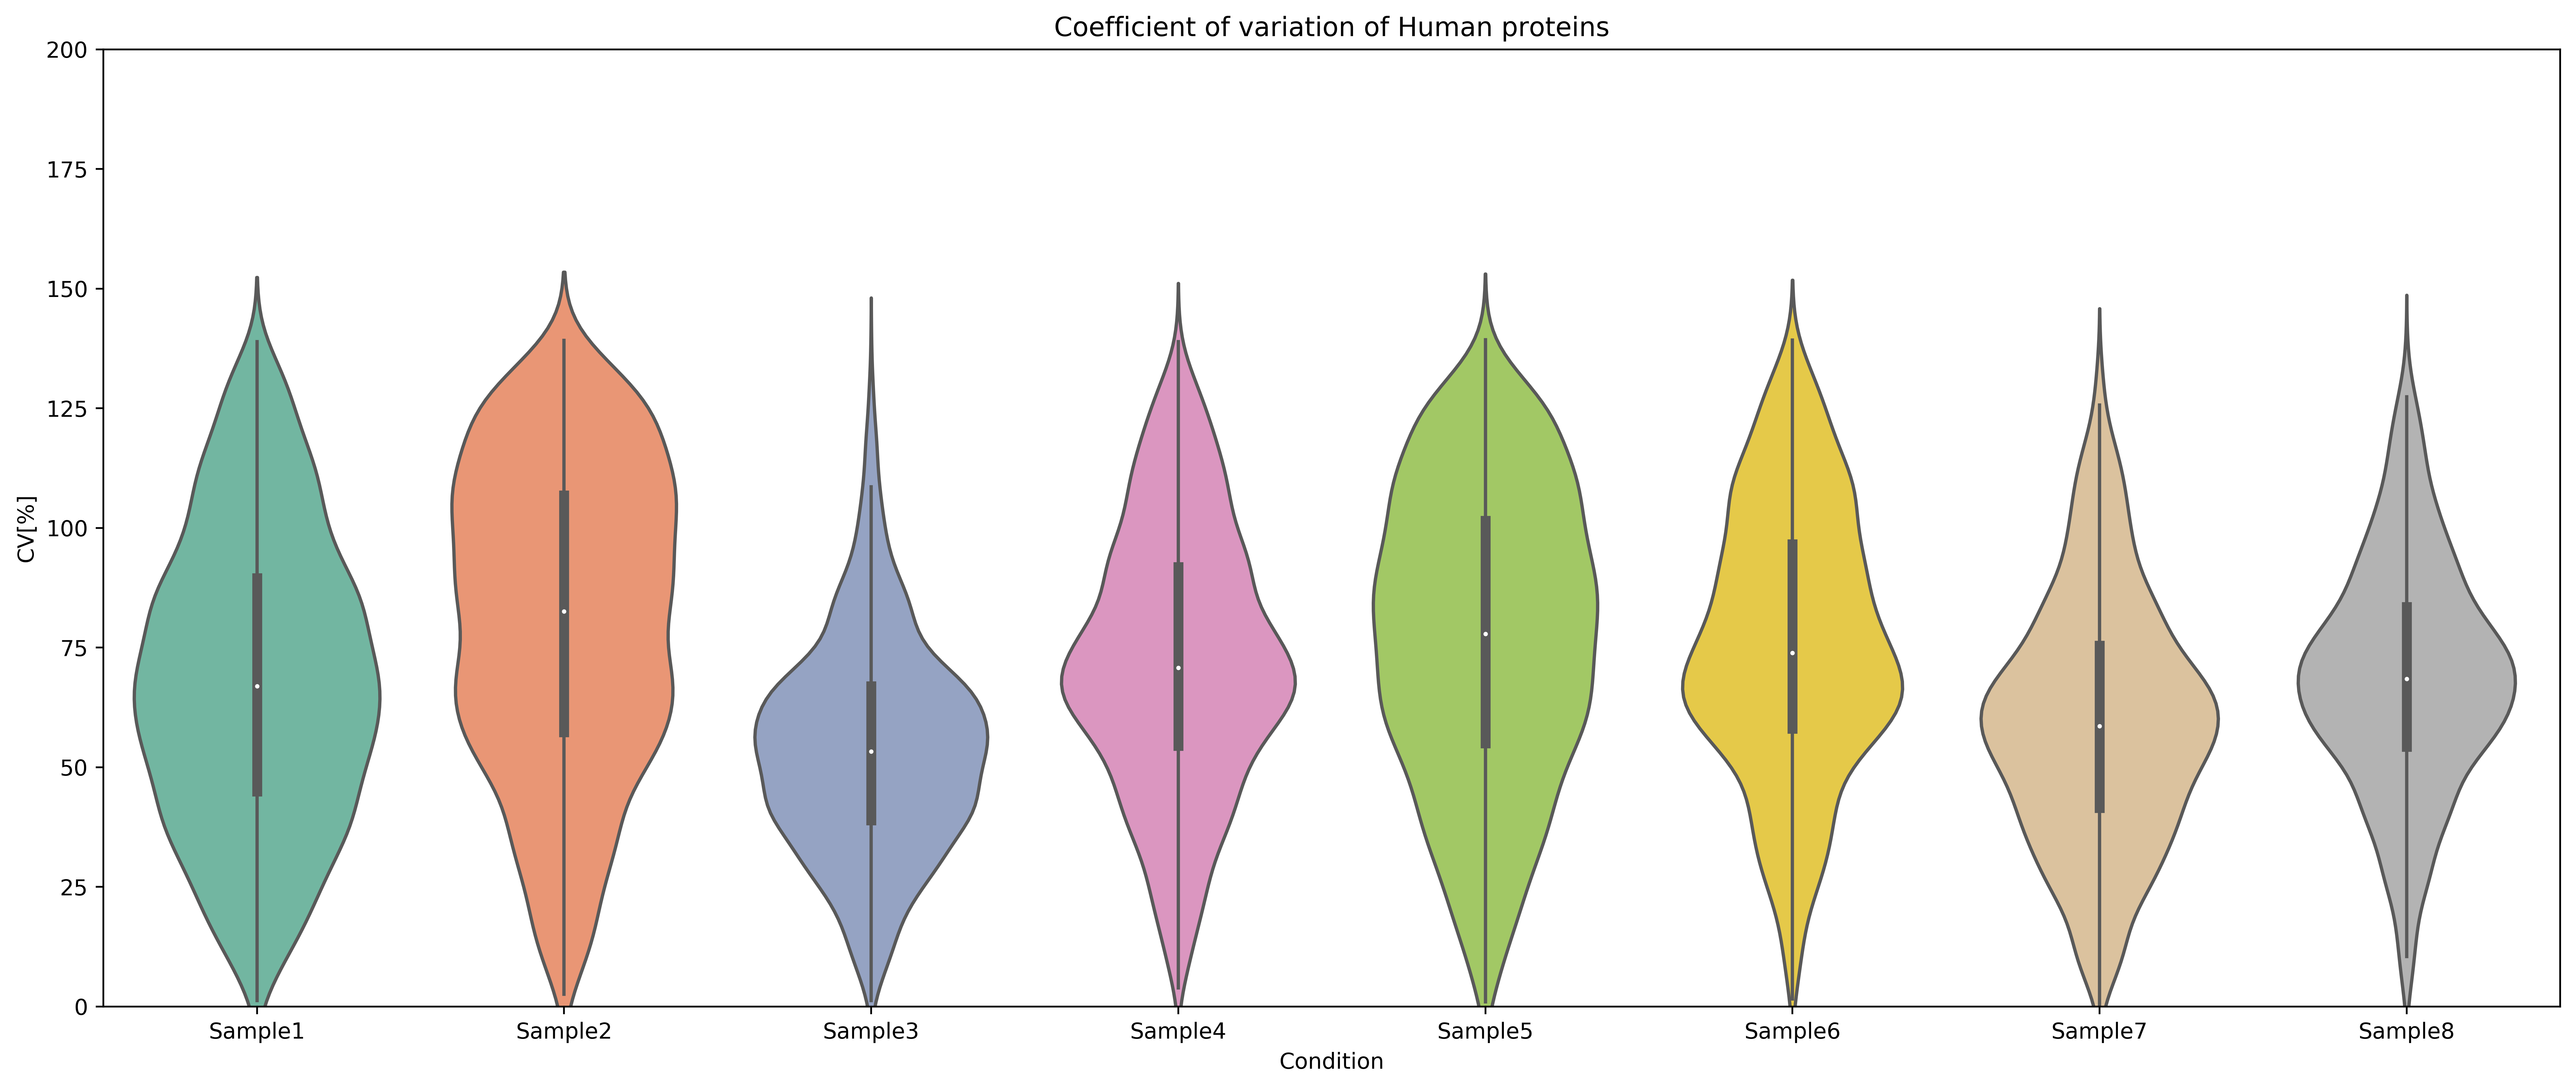

In [8]:
b_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[quantms['ProteinName'].str.contains("HUMAN")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]
            
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
            tech_intensity.append(np.sum(pep_intensity))
            
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        b_data = b_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Human proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=b_data, scale= "count", palette="Set2", 
               order=['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5','Sample6', 'Sample7', 'Sample8'])

plt.show()

### QCplots and Calculate FC

In [9]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]
# No fraction
raw.om$Fraction <- rep(1, nrow(raw.om))

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)
 
# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-07 18:09:04] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-07 18:09:04] ** Fractionation handled.
INFO  [2021-12-07 18:09:06] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-12-07 18:09:08] ** Log2 intensities under cutoff = 13.941  were considered as censored missing values.
INFO  [2021-12-07 18:09:08] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-12-07 18:09:08] ** Use all features that the dataset originally has.
INFO  [2021-12-07 18:09:09] 
 # proteins: 3405
 # peptides per protein: 1-138
 # features per peptide: 1-1
INFO  [2021-12-07 18:09:09] Some proteins have only one feature: 
 sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,
 sp|A0A075B767|PAL4H_HUMAN,
 sp|A2AJT9|BCLA3_HUMAN,
 sp|A4D1E9|GTPBA_HUMAN,
 sp|A6NCE7|MP3B2_HUMAN;sp|Q9GZQ8|MLP3B_HUMAN ...
INFO  [2021-12-07 18:09:09] 
                    Sample1 Sample2 Sample3 Sample4 Sample5 Sample

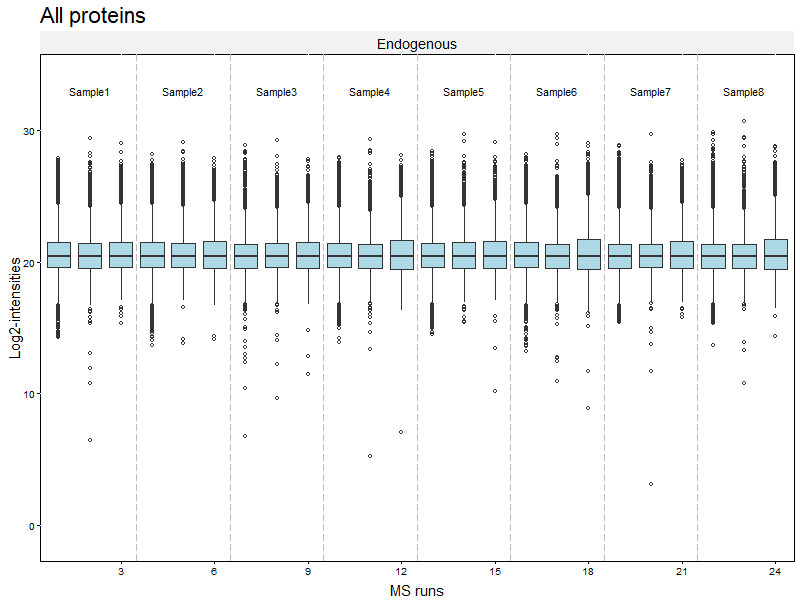

In [10]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|Q5JVX7|CA141_HUMAN"
  |========================================                              |  57%


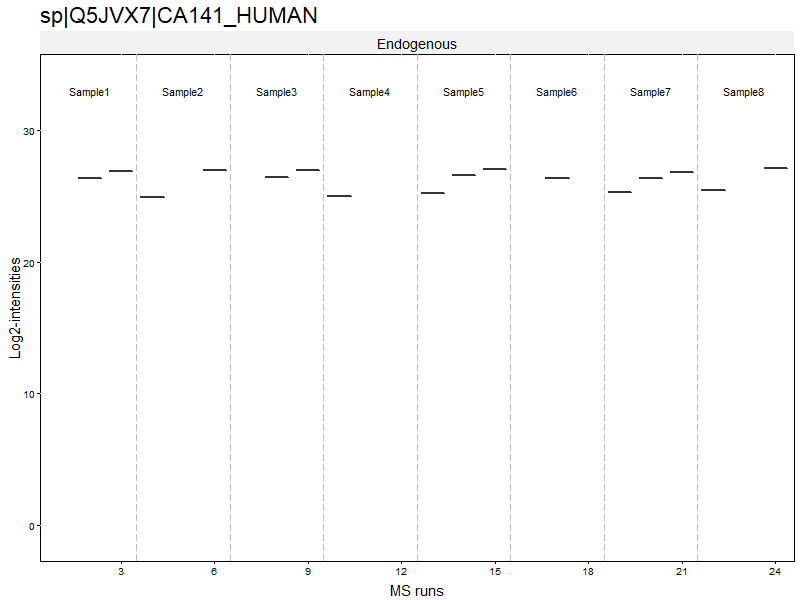

In [11]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


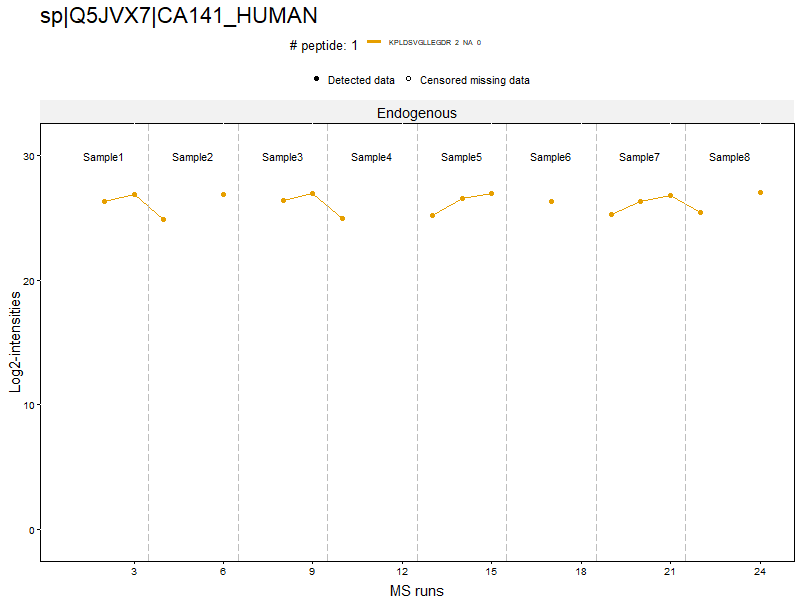

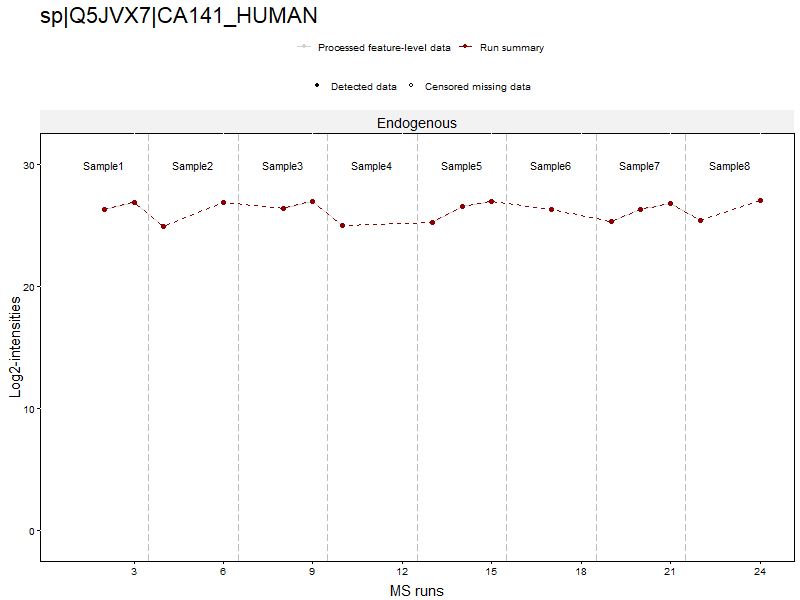

In [12]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |===========================                                           |  39%


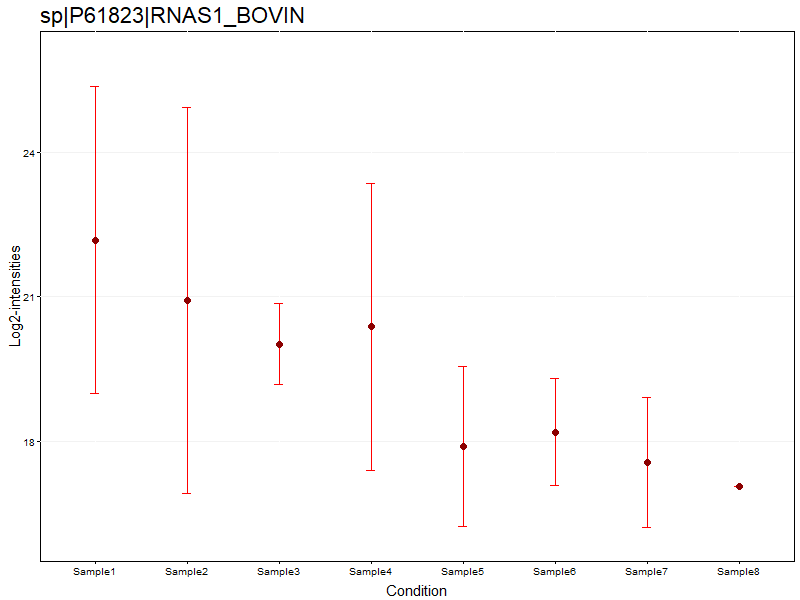

In [13]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("sp|P61823|RNAS1_BOVIN", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [14]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,
                      0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,0,1,
                      0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,1,1,0,
                     0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,0,1,1,1,0,0,0,
                     0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,
                     0,-1,0,0,0,0,0,-1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,
                     -1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
comparison <- matrix(comparison_matrix, nrow=28)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1")
print(comparison)

[1] "Sample1" "Sample2" "Sample3" "Sample4" "Sample5" "Sample6" "Sample7"
[8] "Sample8"
     Sample1 Sample2 Sample3 Sample4 Sample5 Sample6 Sample7 Sample8
8vs7       0       0       0       0       0       0      -1       1
8vs6       0       0       0       0       0      -1       0       1
8vs5       0       0       0       0      -1       0       0       1
8vs4       0       0       0      -1       0       0       0       1
8vs3       0       0      -1       0       0       0       0       1
8vs2       0      -1       0       0       0       0       0       1
8vs1      -1       0       0       0       0       0       0       1
7vs6       0       0       0       0       0      -1       1       0
7vs5       0       0       0       0      -1       0       1       0
7vs4       0       0       0      -1       0       0       1       0
7vs3       0       0      -1       0       0       0       1       0
7vs2       0      -1       0       0       0       0       1       0
7vs1      -1   

In [15]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-12-07 18:11:03]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-12-07 18:11:47]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of UPS1 quantified proteins

In [16]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs7,inf,NaN,NaN,NaN,NaN,0.0,oneConditionMissing,0.833333,0.0
1,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs6,-0.315094,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
2,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs5,-0.172107,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
3,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs4,-0.104771,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
4,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs3,inf,NaN,NaN,NaN,NaN,0.0,oneConditionMissing,0.833333,0.0


[21.462931739558186, 21.91787577586176, 30.357474069037316, 97.37867565008341, 167.31359586192409, 165.60696957017444, 119.24432403922569, 11.529224770240116, 20.808939614373816, 103.42242782101928, 185.45522409329345, 172.62881129572514, 141.6173264427116, 18.276038015956075, 89.44969671248028, 199.90178115071018, 162.88555803273337, 129.87424342440497, 62.80428255127592, 118.0709858699094, 113.23203522732825, 94.75421930463466, 72.52698388607043, 42.50455256643168, 37.90554738211254, 28.652881593045333, 26.98846150618204, 28.00645110188372]


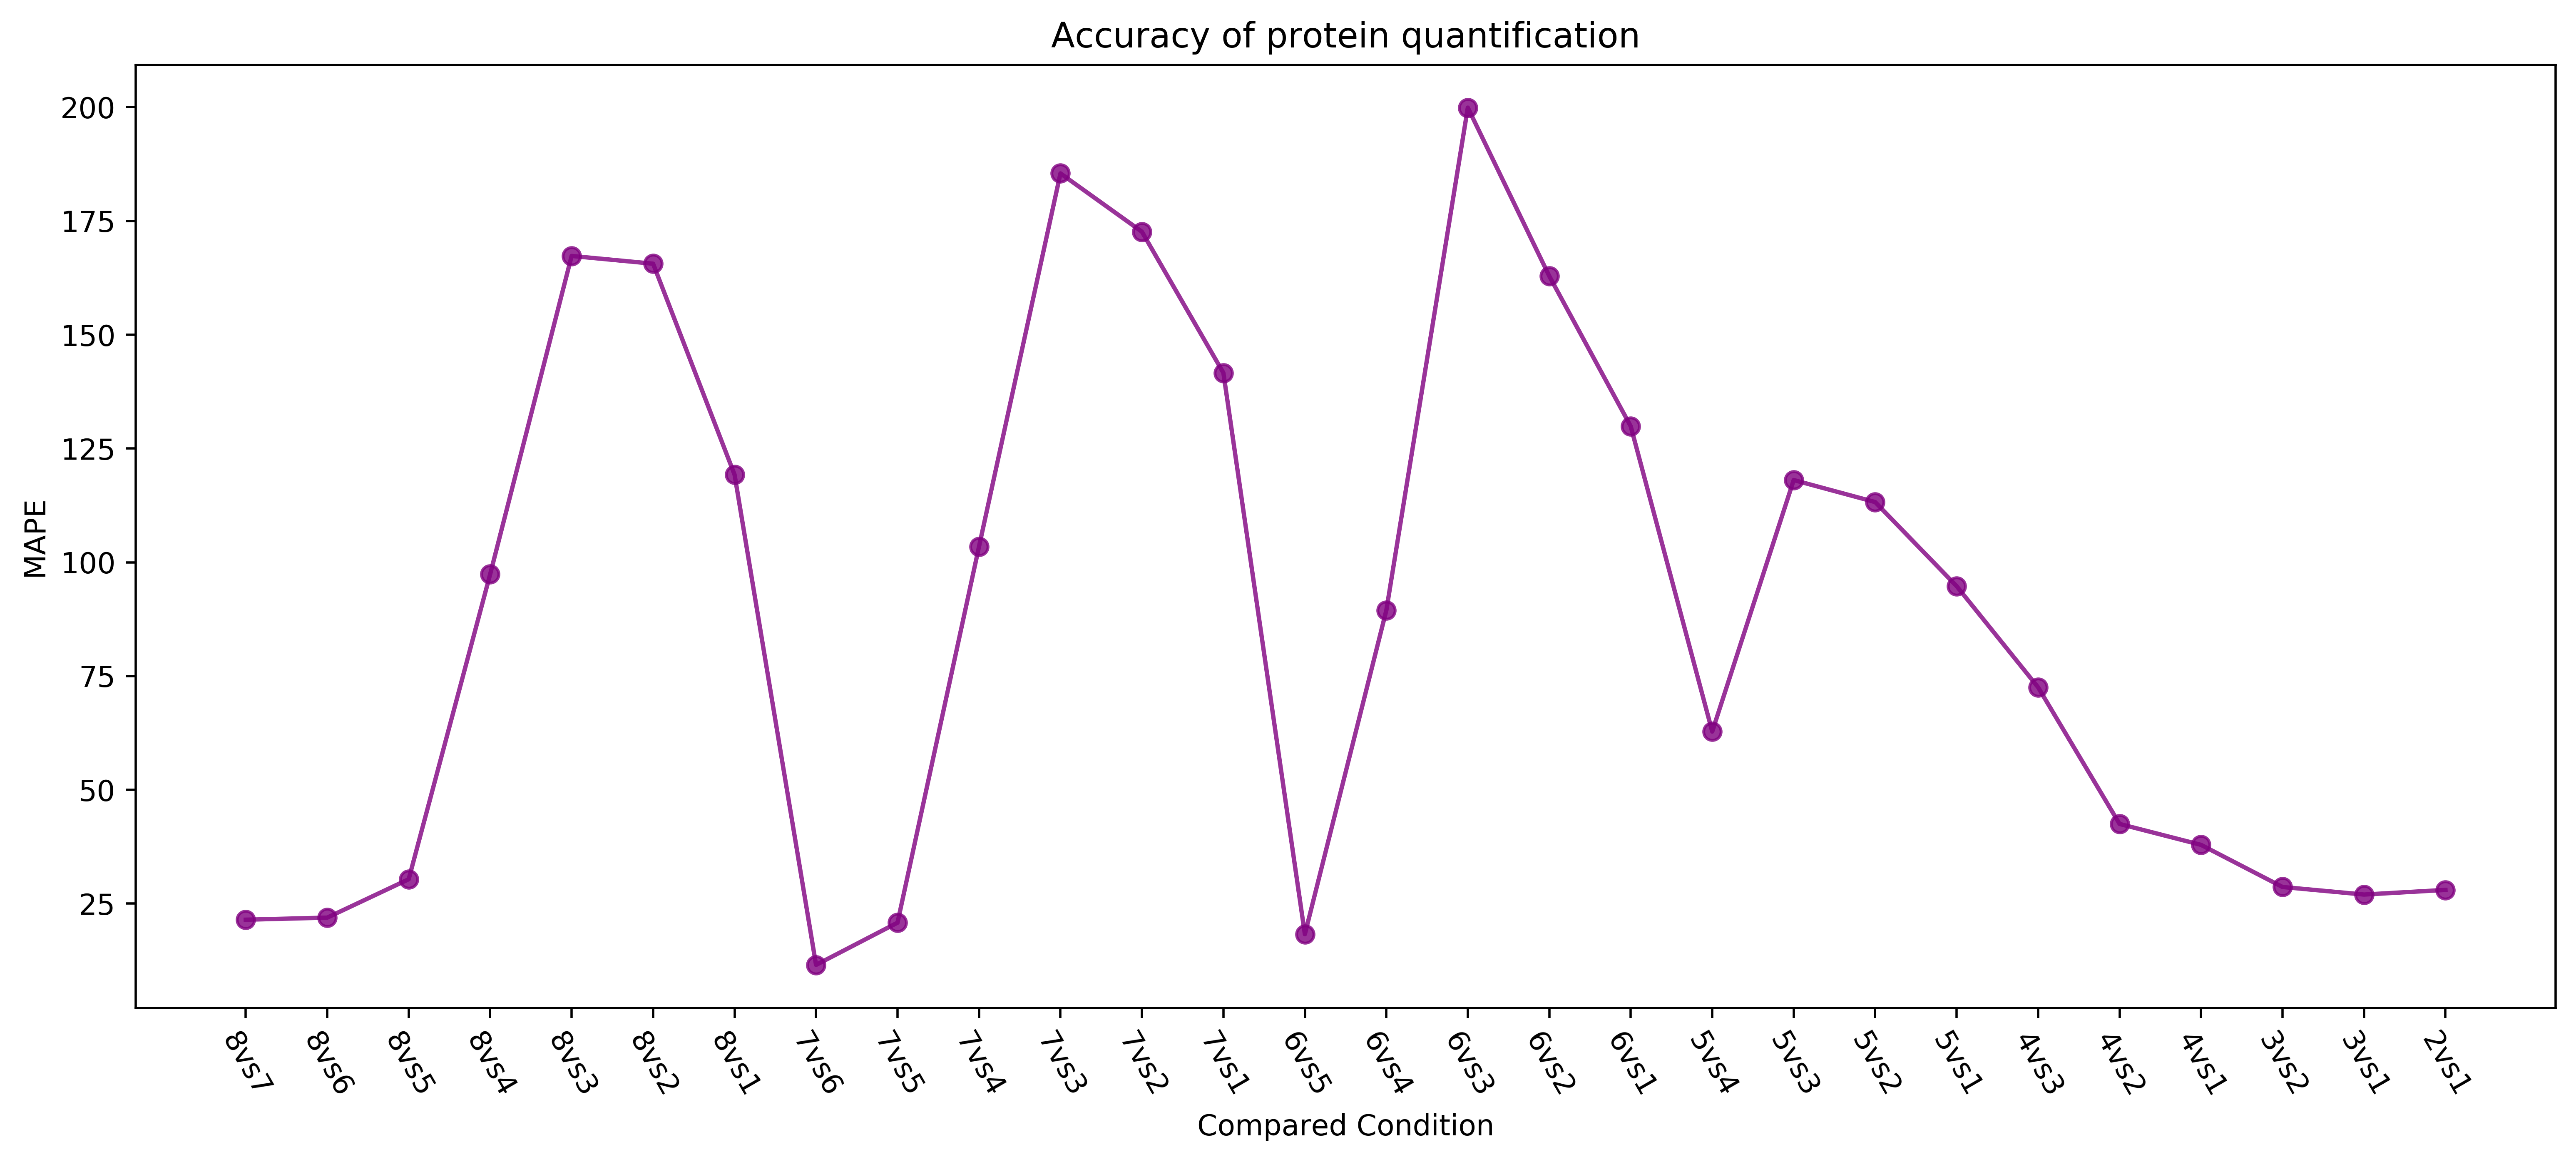

In [19]:
# calculate MAPE
import math
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

Master_Mix1_Mass = {'1': 1.5, '2': 1.65, '3': 1.815, '4': 1.995, '5': 15, '6': 16.515, '7': 18.165, '8': 19.995}
Master_Mix2_Mass = {'1': 100, '2': 62.995, '3': 39.685, '4': 25, '5': 2, '6': 1.26, '7': 0.795, '8': 0.5}
Master_Mix3_Mass = {'1': 0.05, '2': 0.2, '3': 0.8, '4': 3.2, '5': 12.8, '6': 51.2, '7': 204.8, '8': 819.2}

MAPE = []
nonHuman_comp = compar_res[-compar_res['Protein'].str.contains("HUMAN")]
conditions = ["8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1"]
for condition in conditions:
    t = nonHuman_comp[nonHuman_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        if protein in Master_Mix1:
            expected_FC = float(Master_Mix1_Mass[condition.split("vs")[0]]) / float(Master_Mix1_Mass[condition.split("vs")[1]])
        elif protein in Master_Mix2:
            expected_FC = float(Master_Mix2_Mass[condition.split("vs")[0]]) / float(Master_Mix2_Mass[condition.split("vs")[1]])
        else:
            expected_FC = float(Master_Mix3_Mass[condition.split("vs")[0]]) / float(Master_Mix3_Mass[condition.split("vs")[1]])
            
        experimental_FC = math.pow(2, t[t['Protein'] == protein]['log2FC'])    
        ape.append(np.abs(expected_FC - experimental_FC) / expected_FC * 100)
        
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(28), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(28), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared Condition")
plt.ylabel("MAPE")
plt.xticks(rotation=300)
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [20]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
28,sp|A0A075B767|PAL4H_HUMAN,8vs7,1.390983,1.924860,0.722641,4.0,0.509893,0.999034,NaN,0.166667,0.000000
31,sp|A0A075B767|PAL4H_HUMAN,8vs4,-0.320090,2.108579,-0.151804,4.0,0.886691,0.998845,NaN,0.333333,0.000000
33,sp|A0A075B767|PAL4H_HUMAN,8vs2,-0.609660,2.582471,-0.236076,4.0,0.824969,0.999693,NaN,0.500000,0.000000
34,sp|A0A075B767|PAL4H_HUMAN,8vs1,-0.527802,2.582471,-0.204379,4.0,0.848035,0.999662,NaN,0.500000,0.000000
37,sp|A0A075B767|PAL4H_HUMAN,7vs4,-1.711073,1.924860,-0.888933,4.0,0.424267,0.999982,NaN,0.166667,0.000000
39,sp|A0A075B767|PAL4H_HUMAN,7vs2,-2.000643,2.434777,-0.821694,4.0,0.457405,0.999944,NaN,0.333333,0.000000
40,sp|A0A075B767|PAL4H_HUMAN,7vs1,-1.918785,2.434777,-0.788074,4.0,0.474730,0.999737,NaN,0.333333,0.000000
51,sp|A0A075B767|PAL4H_HUMAN,4vs2,-0.289570,2.582471,-0.112129,4.0,0.916123,0.999094,NaN,0.500000,0.000000
52,sp|A0A075B767|PAL4H_HUMAN,4vs1,-0.207713,2.582471,-0.080432,4.0,0.939757,0.999520,NaN,0.500000,0.000000
55,sp|A0A075B767|PAL4H_HUMAN,2vs1,0.081857,2.981981,0.027451,4.0,0.979415,0.999318,NaN,0.666667,0.000000


#### ROC curve based on pvalue

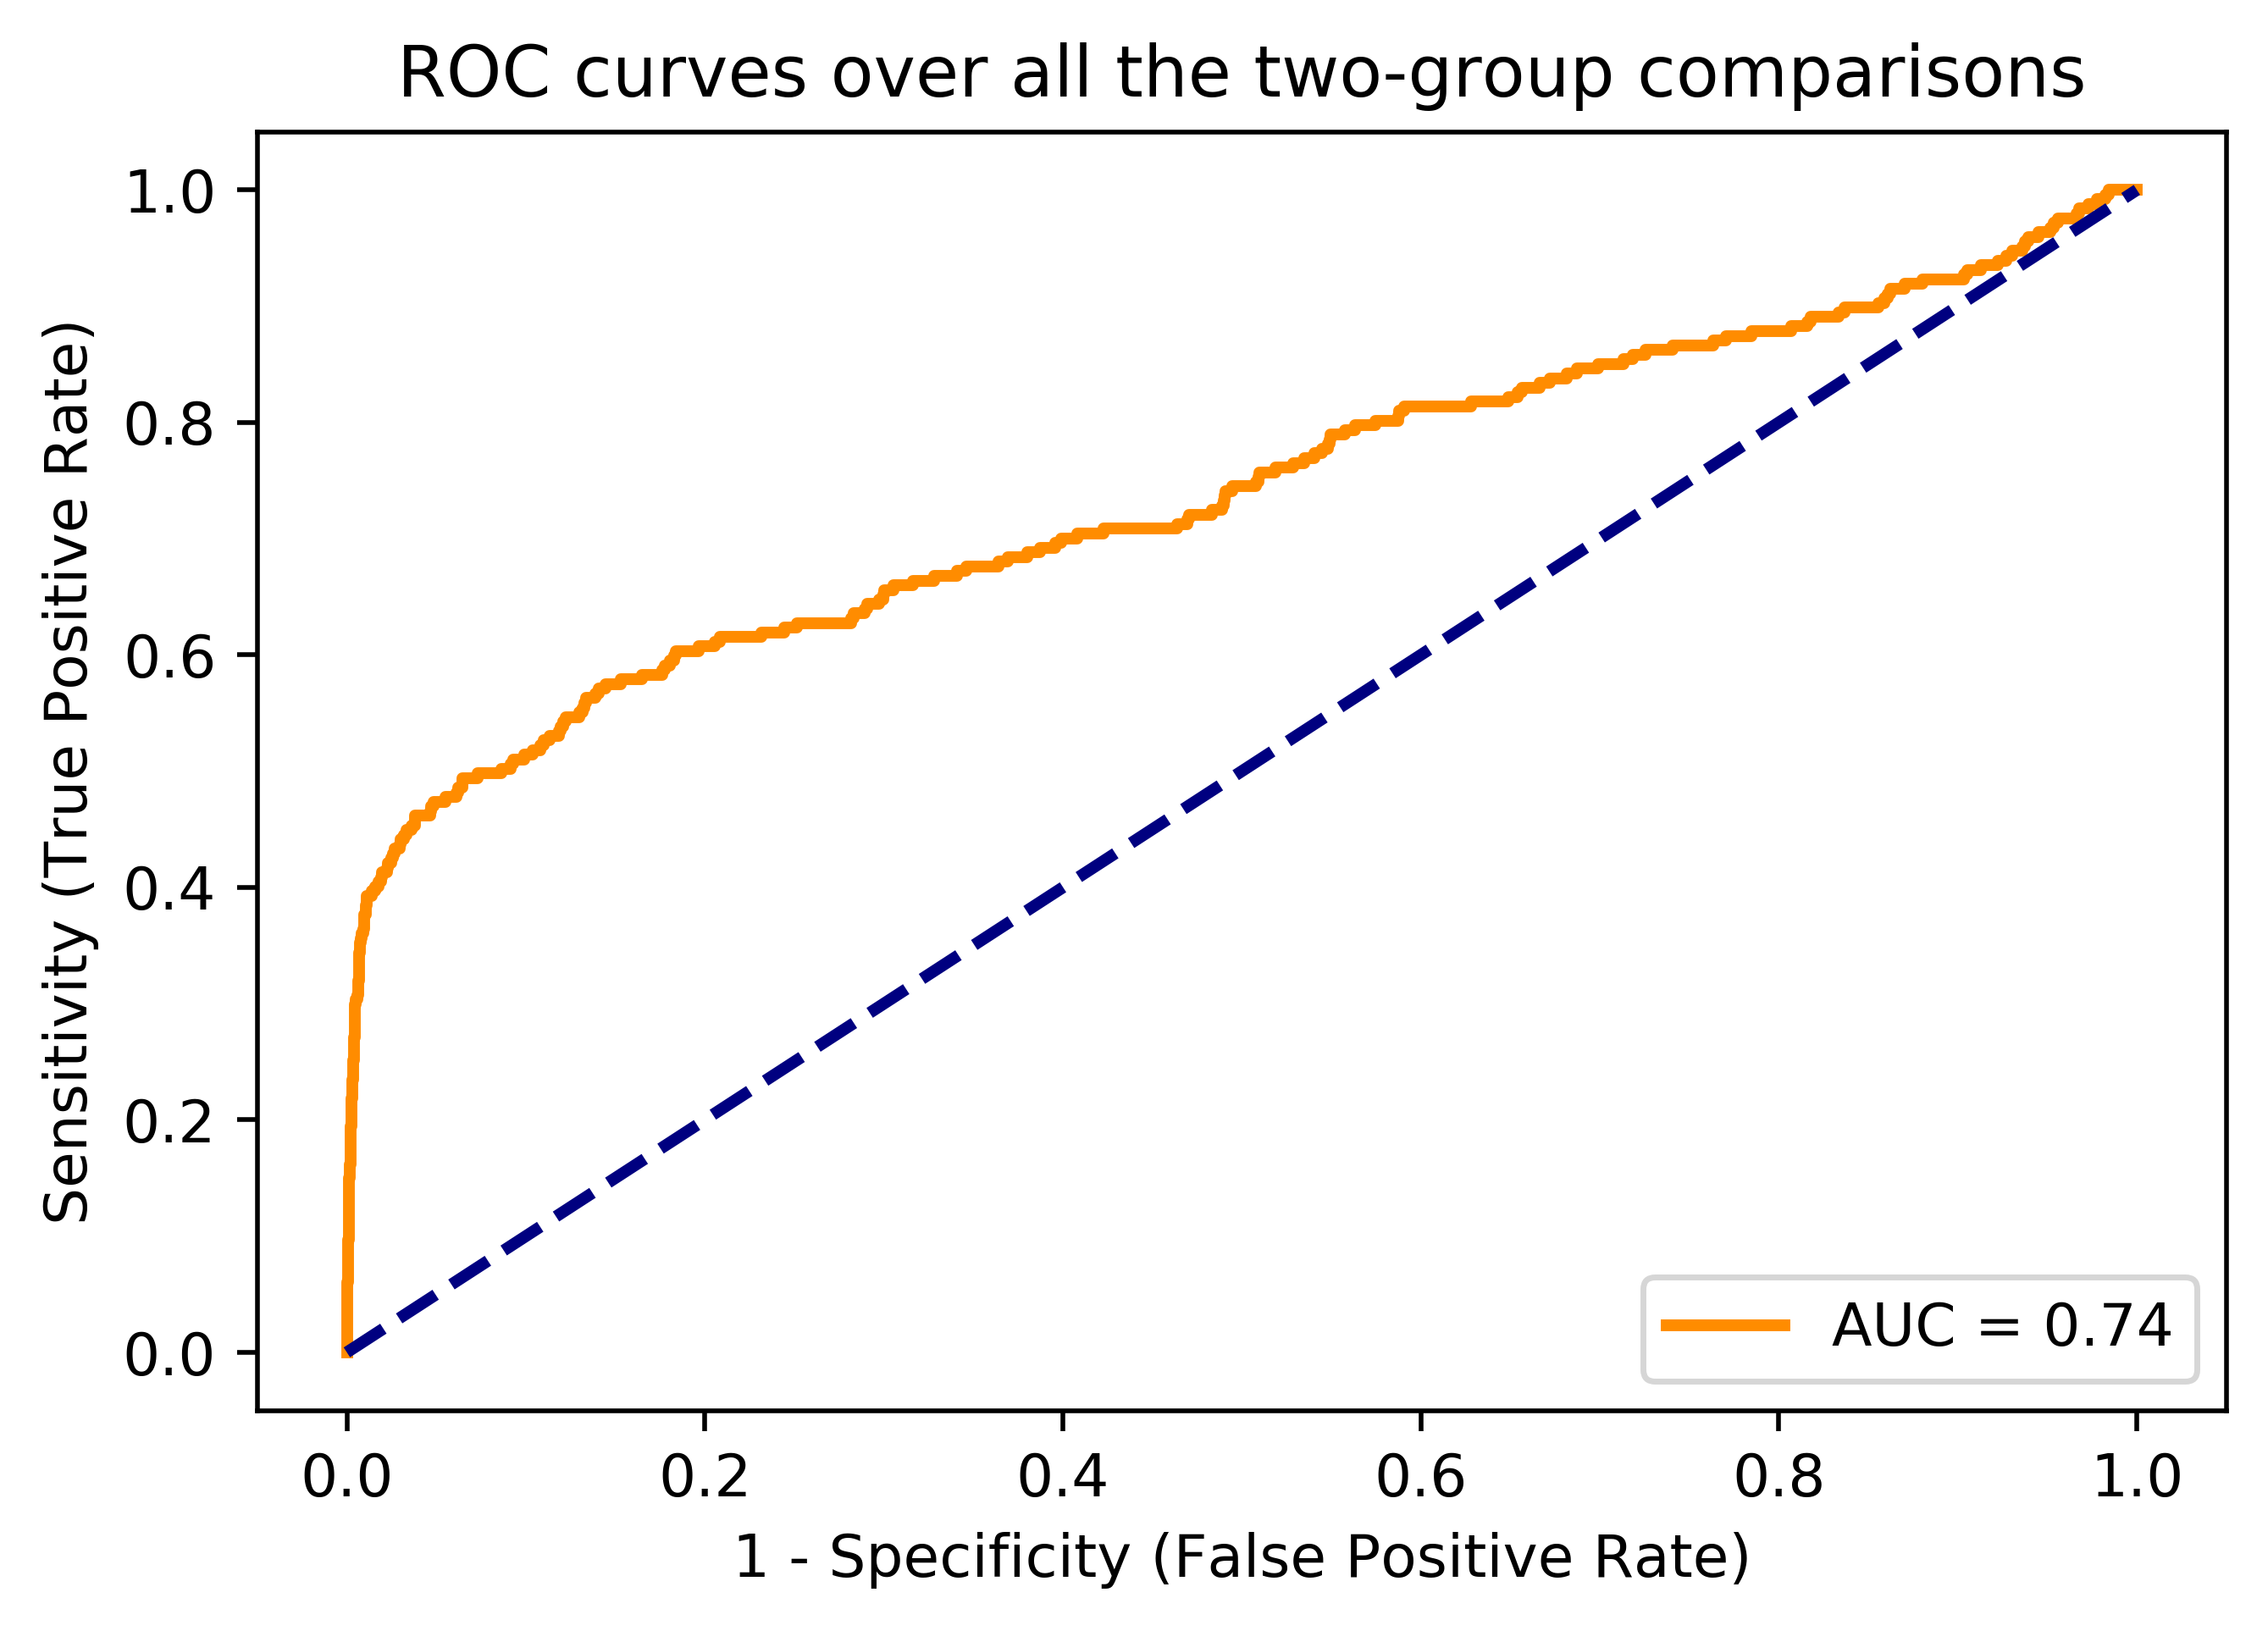

In [25]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['pvalue']
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

m = Master_Mix1 + Master_Mix2 + Master_Mix3

compar_res['y'] = compar_res['Protein'].map(lambda x: (x in m and 1) or ("HUMAN" in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

#### ROC curve based on adj.pvalue

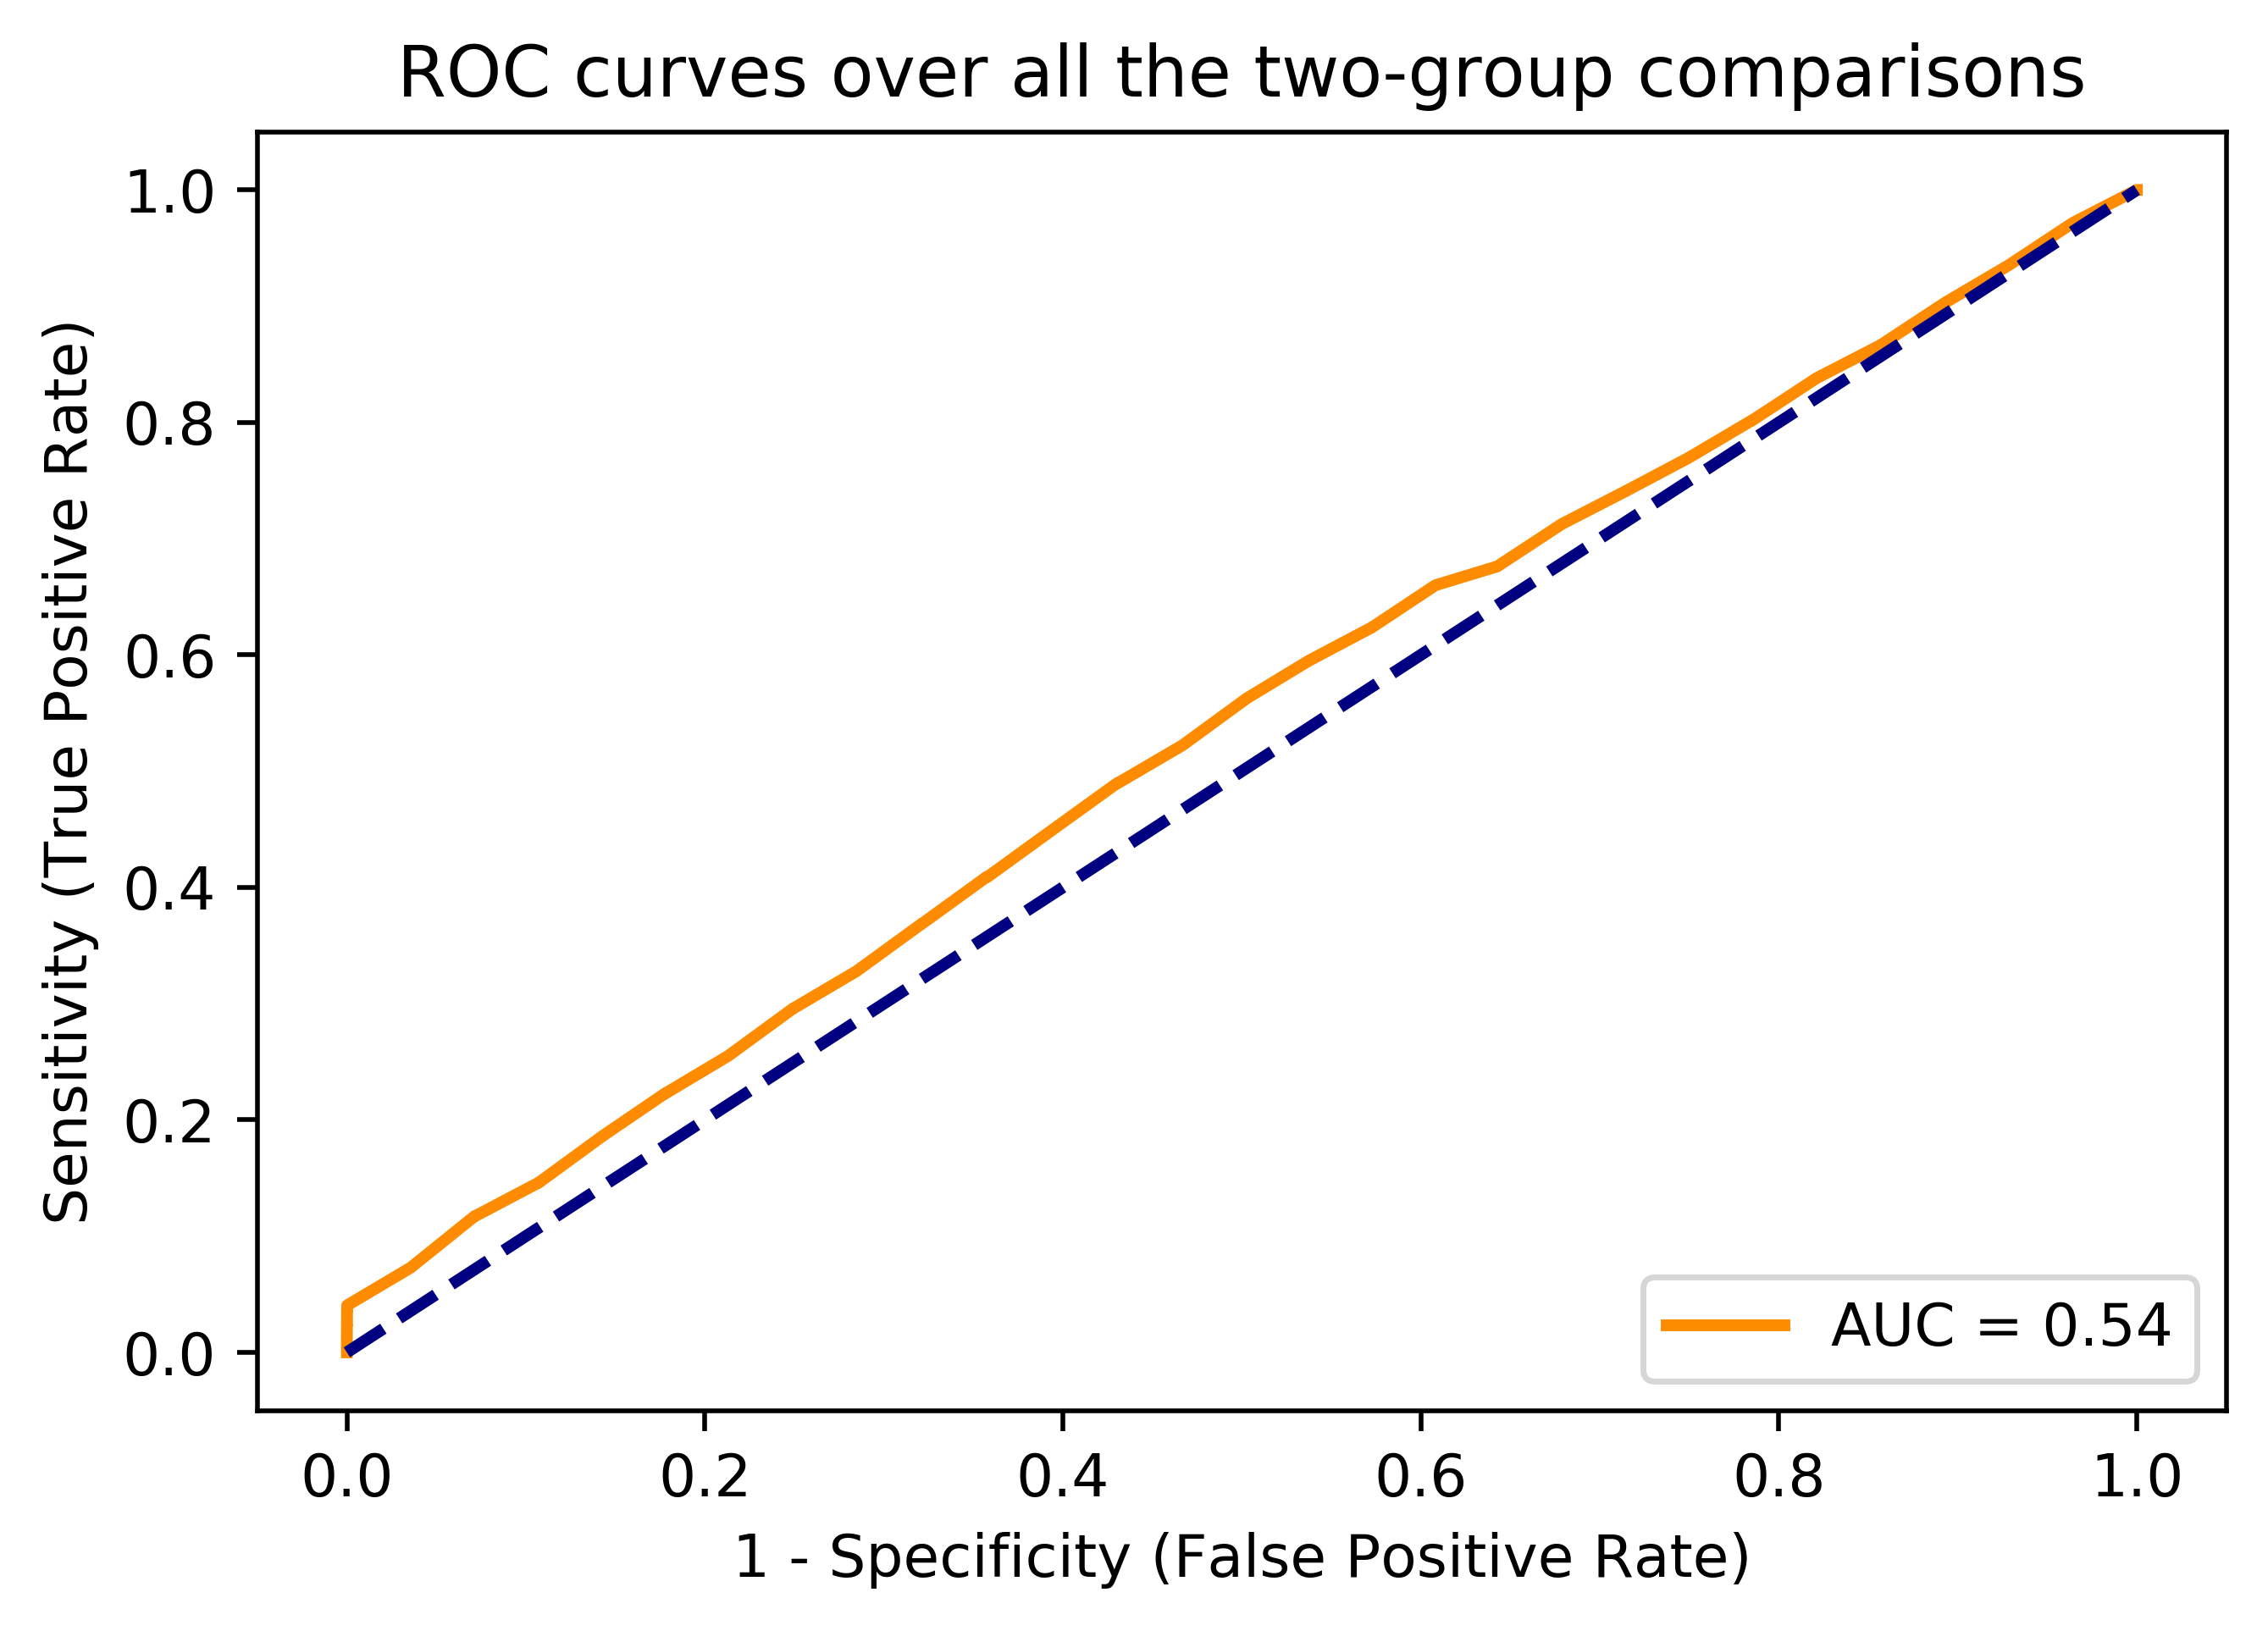

In [27]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['adj.pvalue']
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

m = Master_Mix1 + Master_Mix2 + Master_Mix3

compar_res['y'] = compar_res['Protein'].map(lambda x: (x in m and 1) or ("HUMAN" in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

#### pAUC within each comparision based on pvalue

Text(0.5, 1.0, 'pAUCs of each two-group comparison')

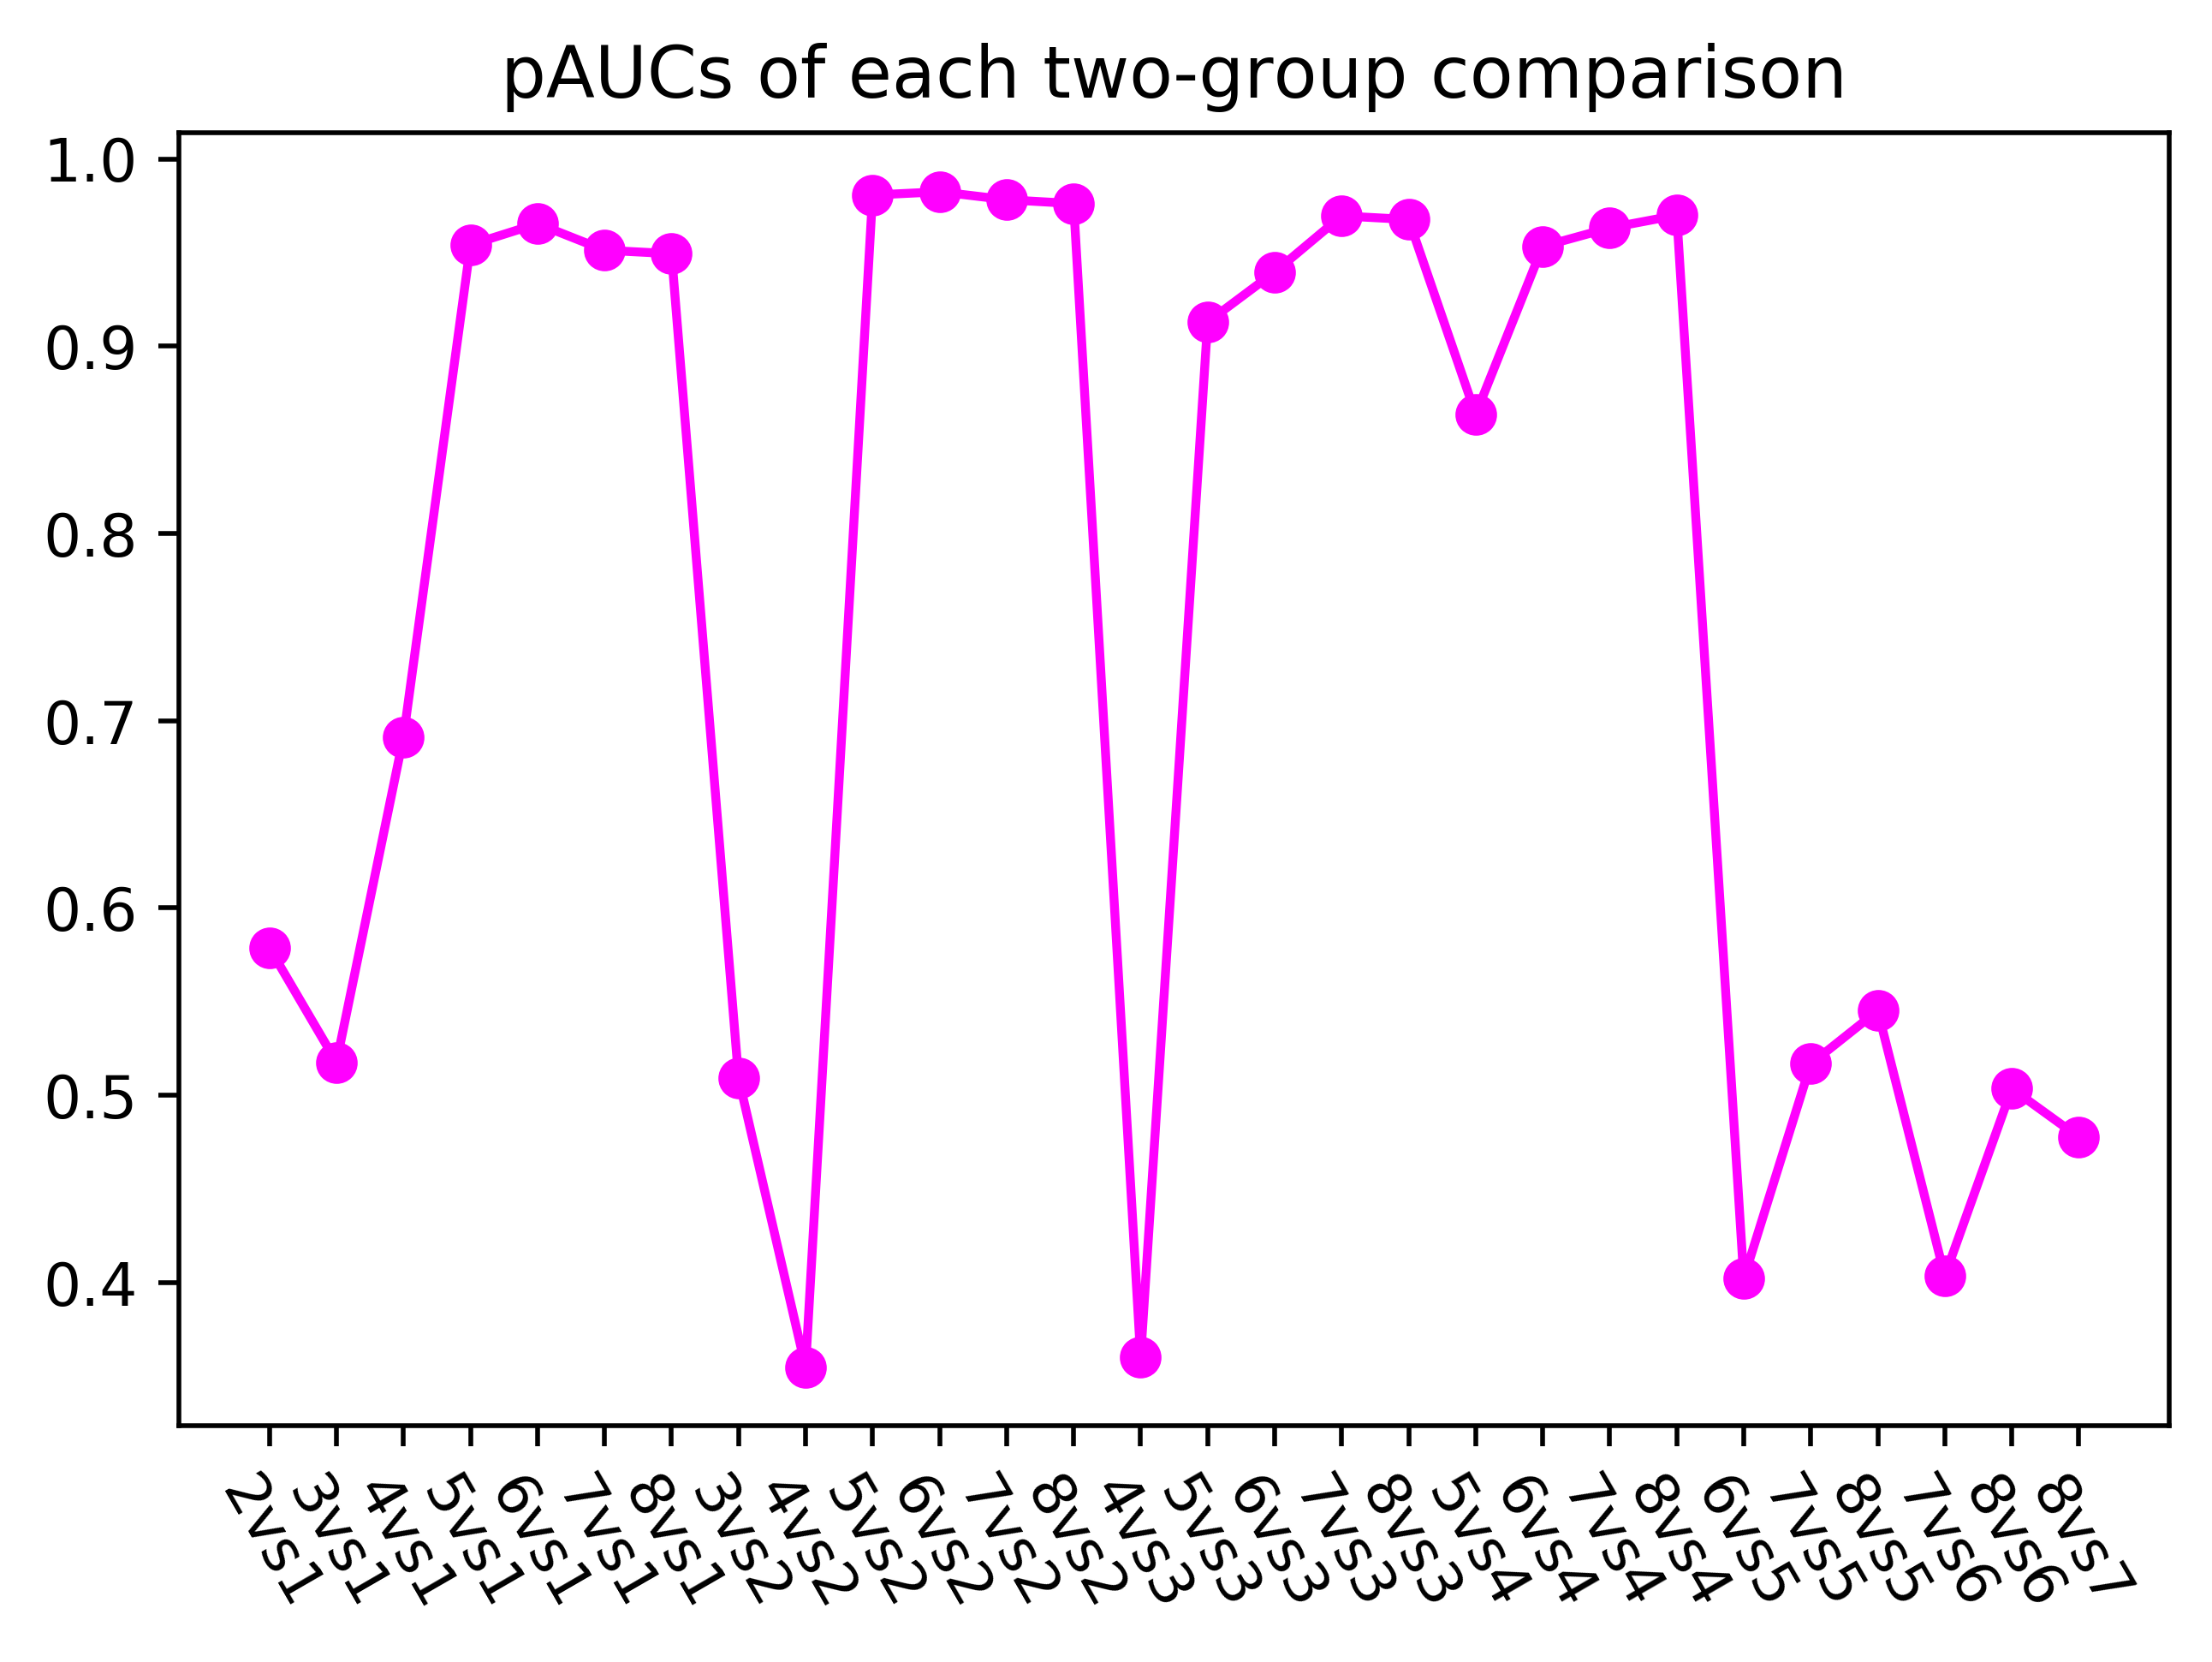

In [32]:
compar_res.head()

compar_res['value'] = 1 - compar_res['pvalue']
conditions = [ "2vs1", "3vs1", "4vs1", "5vs1", "6vs1", "7vs1", "8vs1", 
              "3vs2", "4vs2", "5vs2", "6vs2", "7vs2", "8vs2", "4vs3", "5vs3", "6vs3", "7vs3", "8vs3", 
              "5vs4", "6vs4", "7vs4", "8vs4", "6vs5", "7vs5", "8vs5", "7vs6", "8vs6", "8vs7"
             ]

paucs = []
for condition in conditions:
    comp_condition = compar_res[compar_res['Label'] == condition]
    fpr, tpr, thresholds = metrics.roc_curve(comp_condition['y'].tolist(), comp_condition['value'].tolist(), pos_label = 1)
    pauc = metrics.auc(fpr, tpr)
    paucs.append(pauc)

plt.figure(dpi=500)
plt.plot(range(28), paucs, 'ro-', color='magenta')
plt.xticks(range(28), conditions)
plt.xticks(rotation=300)

plt.title("pAUCs of each two-group comparison")

In [23]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (-group['Protein'].str.contains("HUMAN"))])
    TP = len(differential_proteins[-differential_proteins['Protein'].str.contains("HUMAN")]['Protein'])
    FP = len(differential_proteins[differential_proteins['Protein'].str.contains("HUMAN")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

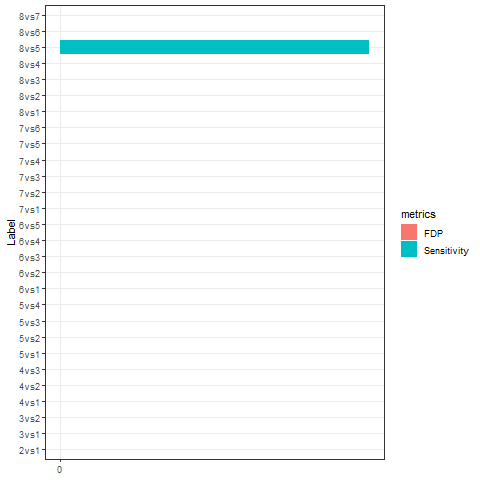

In [24]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
conditions = c("8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)